In [ ]:
%load_ext autoreload
%autoreload 2
import os
import keras
import sys
import time
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.segmentation import find_boundaries
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
model = inc_net.InceptionV3()

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

images = transform_img_fn([os.path.join('data','cat_mouse.jpg')])

img = images[0]

In [ ]:
class SubPlotter:
        
    def __init__(self, test_epsilons, test_sample_sizes, img, batch_size=10):
        self.i = 0
        self.test_epsilons = test_epsilons
        self.test_sample_sizes = test_sample_sizes
        self.img = img
        self.batch_size = batch_size
        self.num_rows = len(test_epsilons)
        self.num_cols = len(test_sample_sizes) + 1
        self.fig, self.axeslist = plt.subplots(ncols=self.num_cols, nrows=self.num_rows, figsize=(4 * self.num_cols, 5 * self.num_rows))
        
        self.explainer = lime_image.LimeImageExplainer()
        
        print("LIME Random Neighborhood Generation:")
        s = time.time()
        self.rand_expl = self.explainer.explain_instance(img, model.predict, top_labels=1, hide_color=0, 
                                                         num_samples=1000, timed=True, batch_size=batch_size)
        diff = time.time() - s
        print("Total Time: {} seconds".format(diff))
        
        self.plot_all()
        
    def plot_all(self):
        for eps in self.test_epsilons:
            temp, mask = self.rand_expl.get_image_and_mask(self.rand_expl.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
            _sp = self.axeslist.ravel()[self.i]
            _sp.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap=plt.gray())
            _sp.set_title("[LIME Rand] label: {}, contrib".format(self.rand_expl.top_labels[0]))
            _sp.set_axis_off()
            self.i += 1
            
            for sample_size in self.test_sample_sizes:
                print("\nEpsilon: {}, Sample Size: {}".format(eps, sample_size))
                s = time.time()
                eps_expl = self.explainer.explain_instance(img, model.predict, top_labels=1, hide_color=0, num_features=5,
                                                           num_samples=sample_size, timed=False, batch_size=self.batch_size,
                                                           use_bandits=True, epsilon=eps)
                diff = time.time() - s
                print("Total Time: {} seconds".format(diff))
                
                temp, mask = eps_expl.get_image_and_mask(eps_expl.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
                _sp = self.axeslist.ravel()[self.i]
                _sp.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap=plt.gray())
                _sp.set_title("[Epsilon:{}, Sample Size:{}] label: {}, contrib".format(eps, sample_size, eps_expl.top_labels[0]))
                _sp.set_axis_off()
                self.i += 1
                
        plt.tight_layout()
        plt.show()

LIME Random Neighborhood Generation:
Bernoulli Sampling Time: 0.0017287731170654297 seconds
Average Perturbed Data Point Creation Time: 0.004124571800231933 seconds
Average Classification Time: 0.1907863712310791 seconds
Average Time per Loop: 0.00019491094303131104 seconds
data_labels Function: 23.20969557762146 seconds
Feature Selection Time: 0.010796308517456055 seconds
Ridge Regression Time: 0.010085582733154297 seconds
Prediction Time: 0.001569986343383789 seconds
Total Time: 24.939749240875244 seconds

Epsilon: 0.1, Sample Size: 25
Total Time: 4.4148948192596436 seconds

Epsilon: 0.1, Sample Size: 50
Total Time: 3.6577699184417725 seconds

Epsilon: 0.1, Sample Size: 75
Total Time: 3.8467328548431396 seconds

Epsilon: 0.1, Sample Size: 100
Total Time: 4.12712836265564 seconds

Epsilon: 0.1, Sample Size: 125
Total Time: 5.039498805999756 seconds

Epsilon: 0.1, Sample Size: 150
Total Time: 5.303136825561523 seconds

Epsilon: 0.1, Sample Size: 175
Total Time: 5.513514995574951 second

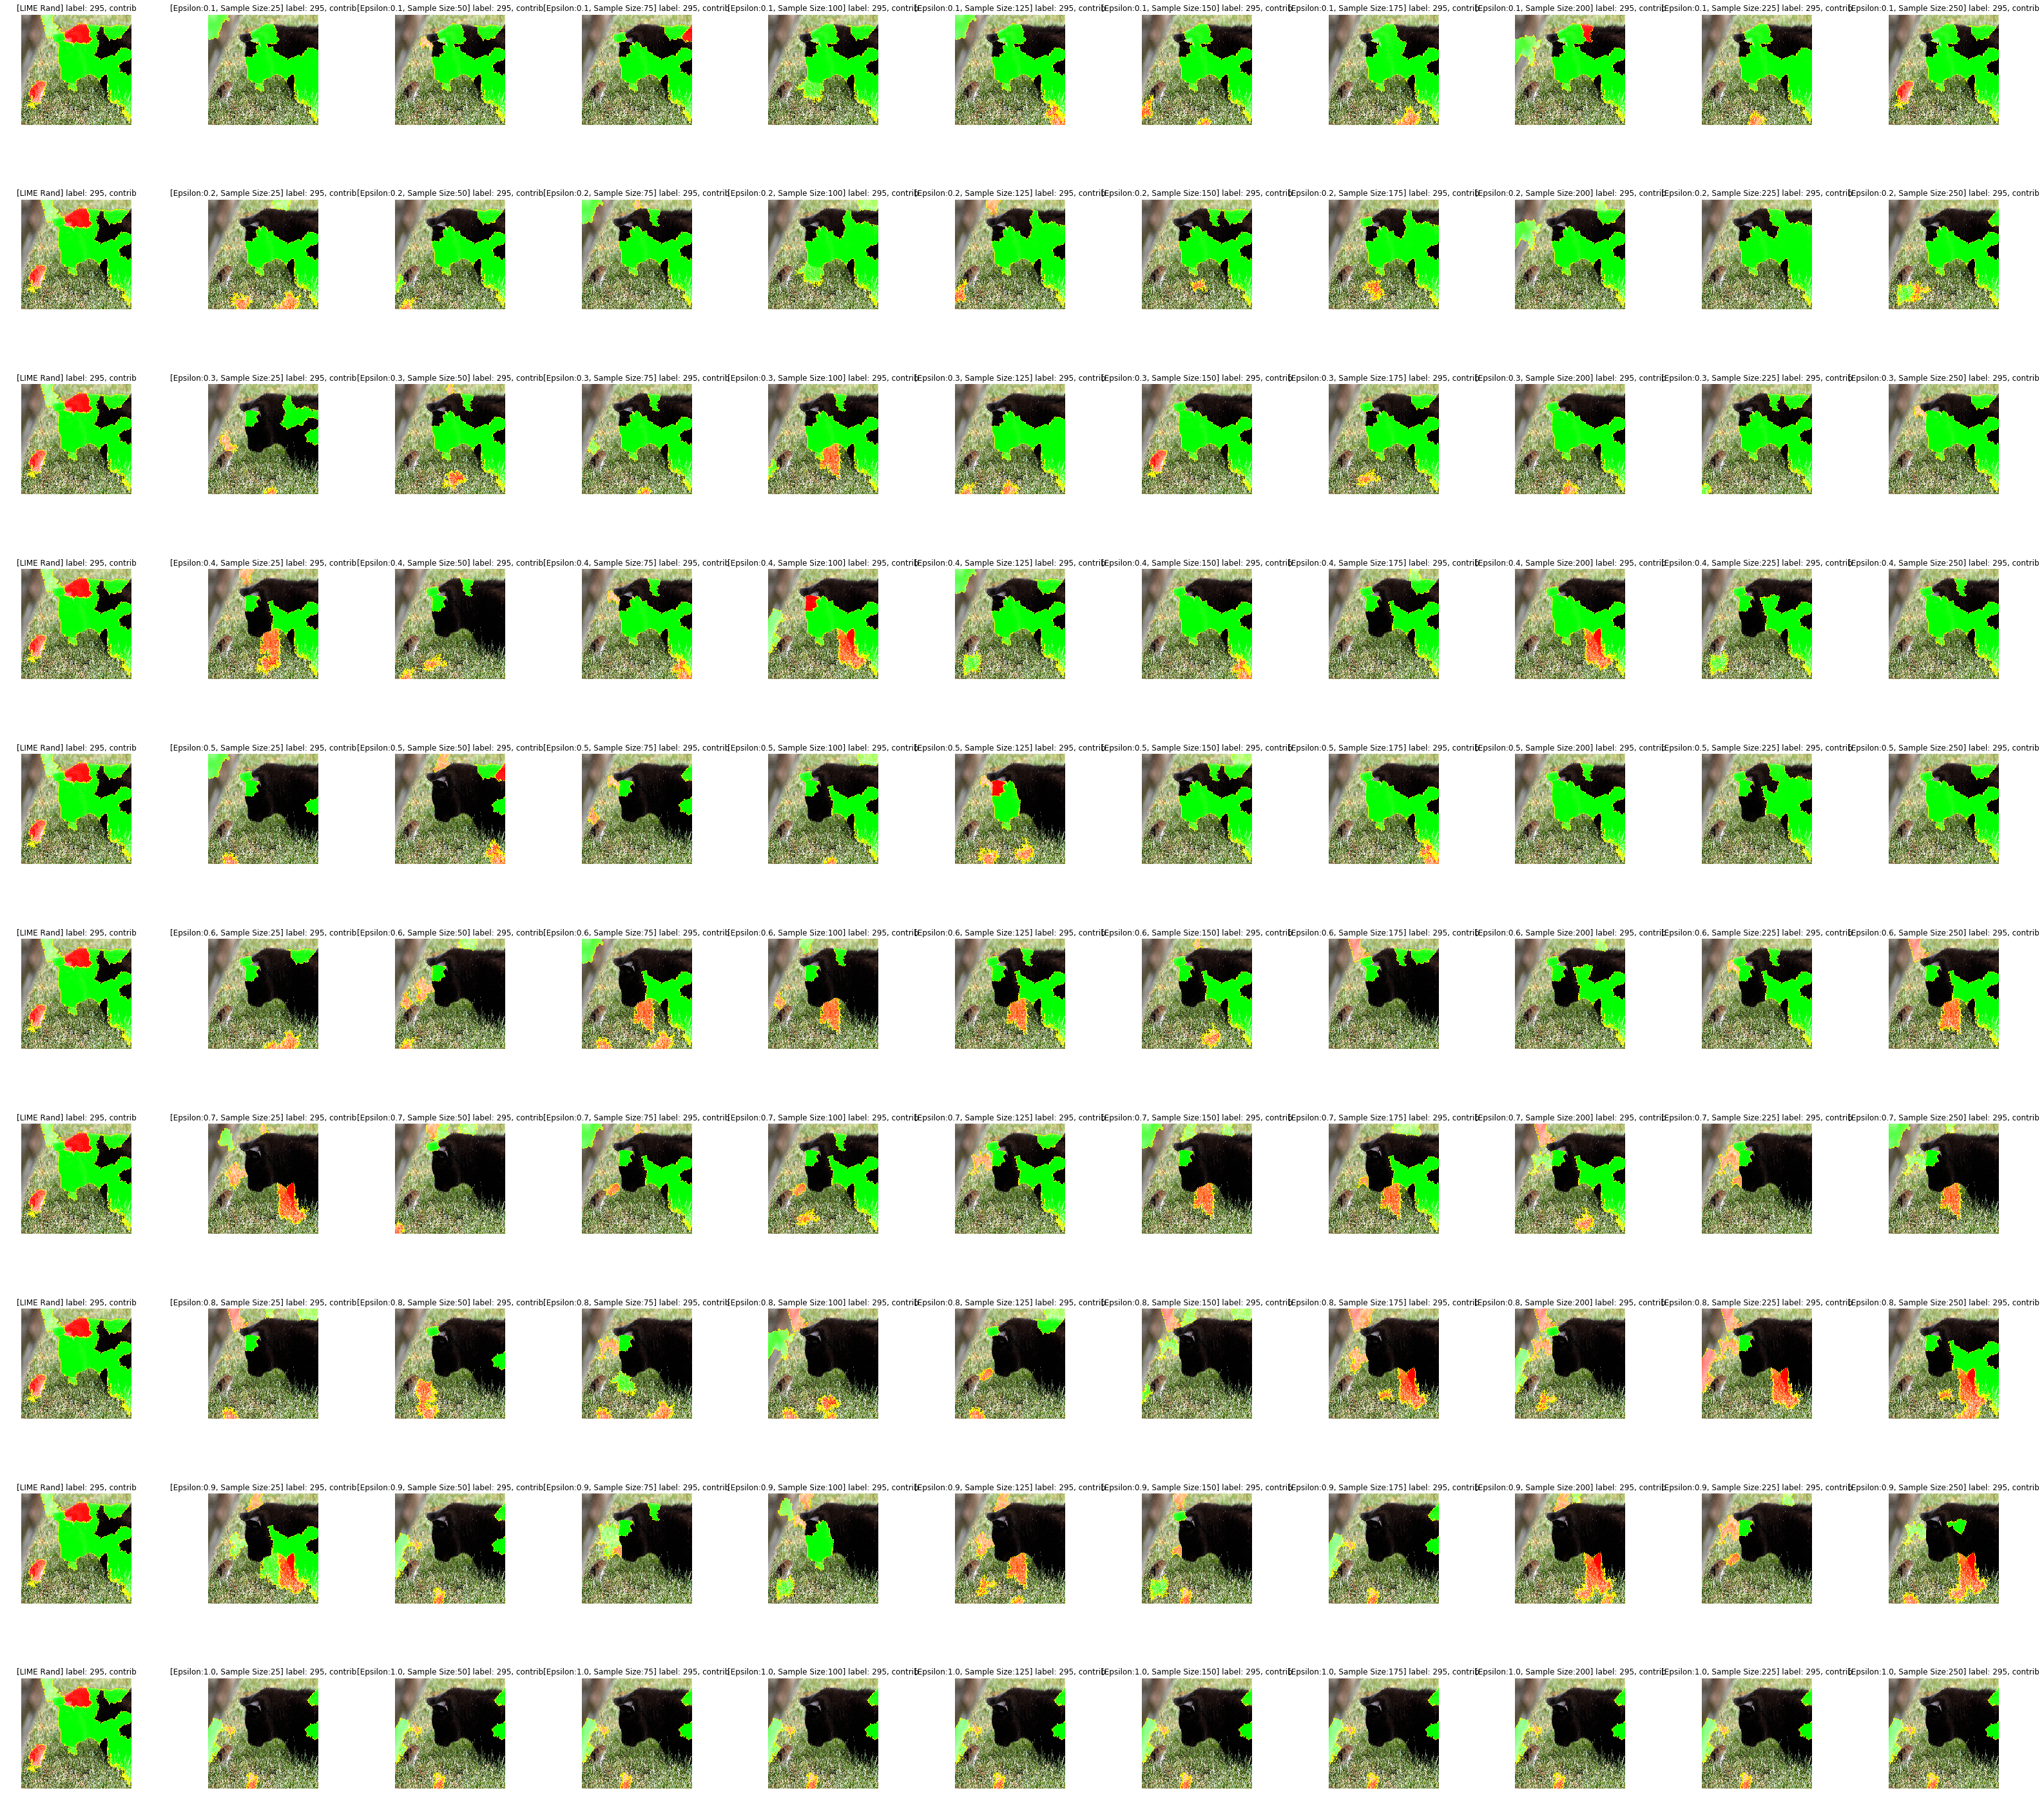

In [4]:
# :params: test_epsilons, test_sample_sizes, img, batch_size=10
SubPlotter([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [25, 50, 75, 100, 125, 150, 175, 200, 225, 250], img)